# API de Processamento de Imagens com AWS

Neste projeto, focaremos em construir uma solução *end-to-end* para o alinhamento de imagens de texto tortas, utilizando a infraestrutura e os serviços disponíveis na AWS (Amazon Web Services). O objetivo principal é demonstrar a capacidade de implementar e integrar diferentes componentes da AWS para criar um sistema automatizado e escalável que possa lidar com o desafio de corrigir a orientação de textos em imagens capturadas sob ângulos variados.

## Configuração Inicial

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

import sys
import ipytest
from pathlib import Path
import base64
import numpy as np
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt

API_FOLDER = Path("src")

sys.path.append(str(API_FOLDER))

DATA_FILEPATH = API_FOLDER / "test_img.png"

ipytest.autoconfig()

%matplotlib inline

# Alinhamento de Imagens de Texto

Em diversos contextos, como no processo de digitalização de documentos ou leitura de textos a partir de imagens capturadas em ângulos não ideais, nos deparamos com o desafio de corrigir a orientação de textos tortos, também conhecido como problema de "*deskew*".

A correção automática da inclinação de imagens de texto não só melhora a legibilidade visual para humanos, mas também otimiza o desempenho de algoritmos de OCR (Reconhecimento Óptico de Caracteres), que são mais eficientes com textos alinhados horizontalmente.

O processo de alinhamento, ou correção de inclinação, envolve várias etapas, utilizando técnicas de processamento de imagens. A lógica implementada segue uma série de passos para identificar e corrigir a inclinação da imagem:

1. **Conversão para Tons de Cinza e Inversão:** Primeiramente, a imagem é convertida para tons de cinza para simplificar o processamento ao reduzir a complexidade de cores. Em seguida, os pixels são invertidos, de modo que o texto (geralmente mais escuro) se torne claro e o fundo (geralmente claro) se torne escuro.

2. **Limiarização (*Thresholding*):** Aplica-se um limiar para binarizar a imagem, ou seja, *pixels* podem assumir apenas dois valores, preto ou branco. Isso ajuda a separar claramente o texto do fundo, facilitando a identificação da área contendo texto.

3. **Determinação do Momento da Imagem e Ângulo de Inclinação:** Utilizando os *pixels* que representam o texto, calcula-se o momento da imagem para encontrar o ângulo de inclinação.

4. **Cálculo do Ângulo de Correção e Rotação:** Com base no ângulo de inclinação identificado, calcula-se o ângulo necessário para corrigir a inclinação da imagem. A imagem é então rotacionada com base neste ângulo para alinhá-la corretamente.

Neste projeto, não entraremos em detalhes específicos sobre a técnica de alinhamento em si ou nos aspectos intrínsecos do algoritmo utilizado.Em vez disso, focaremos na arquitetura e implementação da solução utilizando o AWS API Gateway, mostrando como utilizar serviços como o AWS Lambda, para execução de código *serverless*, e o Amazon ECR (Elastic Container Registry), para armazenamento de imagens Docker com OpenCV instalado. 


In [2]:
def encode_image_to_base64(
        img: np.ndarray
        ) -> str:
    """
    Codifica uma imagem (array da NumPy) diretamente para a representação em string Base64, 
    salvando temporariamente em um arquivo.

    Args:
        img (np.ndarray): A imagem como um array da NumPy para ser codificada.

    Returns:
        str: A representação da imagem codificada em Base64.
    """
    # Caminho temporário para salvar a imagem
    aux_path = '/tmp/tmp_image.png'
    # Salva a imagem no caminho temporário
    cv2.imwrite(aux_path, img)

    # Abre a imagem salva, codifica em Base64, e retorna a string decodificada
    with open(aux_path, "rb") as f:
        encoded_string = base64.b64encode(f.read()).decode("utf-8")

    return encoded_string

encoded_string = encode_image_to_base64(cv2.imread(str(DATA_FILEPATH)))

In [3]:
def decode_base64_to_image(
        encoded_string: str,
        img_path: str = "decoded_img.png"
        ) -> np.ndarray:
    """
    Decodifica uma string Base64 para uma imagem e salva como arquivo, então lê a imagem do arquivo e retorna como um array da NumPy.

    Args:
        encoded_string (str): String Base64 da imagem a ser decodificada.
        img_path (str): Caminho do arquivo onde a imagem decodificada será salva.

    Returns:
        np.ndarray: A imagem decodificada como um array da NumPy.
    """

    img_data = base64.b64decode(encoded_string)
    with open(img_path, "wb") as image_file:
        image_file.write(img_data)

    image = cv2.imread(img_path)
    return image

decoded_im = decode_base64_to_image(encoded_string)


In [4]:
def deskew_image(image):
    """
    Corrige a inclinação da imagem.

    Parâmetros:
        image (numpy.ndarray): Imagem para corrigir.

    Retorna:
        numpy.ndarray: Imagem corrigida.
    """
    # Converte para tons de cinza e inverte as cores
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)

    # Aplica threshold para binarizar e encontrar coordenadas dos pixels não-zero
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))

    # Calcula o ângulo de inclinação
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # Computa a matriz de rotação e aplica a rotação
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated

# deskew image in DATA_FILEPATH
deskewed_im = deskew_image(decoded_im)

In [6]:
encoded_string

'iVBORw0KGgoAAAANSUhEUgAAB64AAAY4CAIAAAChunReAAAgAElEQVR4AezBD4zX9X044Nf7d6K5zj9nKQ6tVm3sXXWVynVIL+2oCvafBSRQm3NrhjRqDrGD9frHlcGku622MNlwZ8RVympxq7Ce5Up1YBGaXh3mlMq6xnMtJdpJoPasDq/2vLx+yTf5JkeQrXZzwsfneUpmBgAAAAAAVFfJzAAAAAAAgOoqmRkAAAAAAFBdJTMDAAAAAACqq2RmAAAAAABAdZXMDAAAAAAAqK6SmQEAAAAAANVVMjMAAAAAAKC6SmYGAAAAAABUV8nMAAAAAACA6iqZGQAAAAAAUF0lMwMAAAAAAKqrZGYAAAAAAEB1lcwMAAAAAACorpKZAQAAAAAA1VUyMwAAAAAAoLpKZgYAAAAAAFRXycwAAAAAAIDqKpkZAAAAAABQXSUzAwAAAAAAqqtkZgAAAAAAQHWVzAwAAAAAAKiukpkBAAAAAADVVTIzAAAAAACgukpmBgAAAAAAVFfJzAAAAAAAgOoqmRkAAAAAAFBdJTMDAAAAAACqq2RmAAAAAABAdZXMDAAAAAAAqK6SmQEAAAAAANVVMjMAAAAAAKC6SmYGAAAAAABUV8nMAAAAAACA6iqZGQAAAAAAUF0lMwMAAAAAAKqrZGYAAAAAAEB1lcwMAAAAAACorpKZAQAAAAAA1VUyMwAAAAAAoLpKZgYAAAAAAFRXycwAAAAAAIDqKpkZAAAAAABQXSUzAwAAAAAAqqtkZgAAAAAAQHWVzAwAAAAAAKiukpkBAAAAAADVVTIzAAAAAACgukpmBgAAAAAAVFfJzAAAAAAAgOoqmRkAAAAAAFBdJTMDAAAAAACqq2RmAAAAAABAdZXMDAAAAAAAqK6SmQEAAAAAANVVMjMAAAAAAKC6SmYGAAAAAABUV8nMAAAAAACA6iqZGQAAAAAAUF0lMwMAAAAAAKqrZGYAAAAAAEB1lcwMAAAAAACorpK

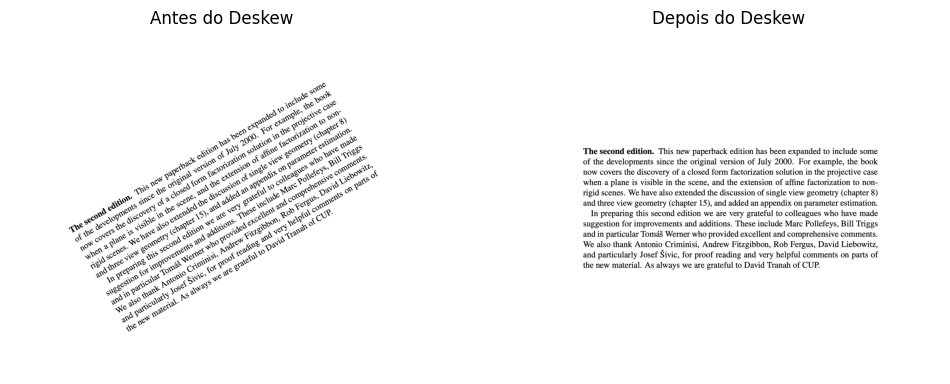

In [38]:
def plot_images(before, after, title_before='Antes', title_after='Depois'):
    """
    Plota duas imagens lado a lado para comparação.

    Parâmetros:
        before (numpy.ndarray): Imagem antes do processamento.
        after (numpy.ndarray): Imagem depois do processamento.
        title_before (str): Título para a imagem antes do processamento.
        title_after (str): Título para a imagem depois do processamento.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ax1, ax2 = axes

    ax1.imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
    ax1.set_title(title_before)
    ax1.axis('off')

    ax2.imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))
    ax2.set_title(title_after)
    ax2.axis('off')

    plt.show()

# Agora, usando a função definida acima para plotar as imagens antes e depois do deskew
plot_images(decoded_im, deskewed_im, 'Antes do Deskew', 'Depois do Deskew')


## Criando o Script de Processamento

Neste projeto, não entraremos em detalhes específicos sobre a técnica de alinhamento em si ou nos aspectos intrínsecos do algoritmo utilizado. Em vez disso, nossa atenção estará voltada para a arquitetura e implementação da solução na AWS, explorando como serviços como Amazon S3 para armazenamento, AWS Lambda para execução de código sem servidor, e Amazon Rekognition para análise de imagem podem ser combinados para criar um pipeline eficiente de processamento de imagens.

Ao final deste projeto, você terá uma visão clara de como projetar e implementar uma solução completa na AWS que não apenas resolve um problema prático de processamento de imagens, mas também demonstra a aplicabilidade de conceitos de cloud computing para desenvolver aplicações robustas e escaláveis. Este conhecimento será valioso para uma ampla gama de aplicações futuras, estabelecendo uma base sólida para projetos mais complexos envolvendo a manipulação e análise automatizada de imagens na nuvem.


In [8]:
%%writefile {API_FOLDER}/app.py

import json
import cv2
import base64
import numpy as np

def encode_image_to_base64(
        img: np.ndarray
        ) -> str:
    """
    Codifica uma imagem (array da NumPy) diretamente para a representação em string Base64, 
    salvando temporariamente em um arquivo.

    Args:
        img (np.ndarray): A imagem como um array da NumPy para ser codificada.

    Returns:
        str: A representação da imagem codificada em Base64.
    """
    # Caminho temporário para salvar a imagem
    aux_path = '/tmp/tmp_image.png'
    # Salva a imagem no caminho temporário
    cv2.imwrite(aux_path, img)

    # Abre a imagem salva, codifica em Base64, e retorna a string decodificada
    with open(aux_path, "rb") as f:
        encoded_string = base64.b64encode(f.read()).decode("utf-8")

    return encoded_string


def decode_base64_to_image(
        encoded_string: str,
        img_path: str = "/tmp/decoded_img.png"  # Alterado para usar o diretório /tmp
        ) -> np.ndarray:
    """
    Decodifica uma string Base64 para uma imagem e salva como arquivo, então lê a imagem do arquivo e retorna como um array da NumPy.

    Args:
        encoded_string (str): String Base64 da imagem a ser decodificada.
        img_path (str): Caminho do arquivo onde a imagem decodificada será salva. Modificado para /tmp/decoded_img.png

    Returns:
        np.ndarray: A imagem decodificada como um array da NumPy.
    """

    img_data = base64.b64decode(encoded_string)
    with open(img_path, "wb") as image_file:
        image_file.write(img_data)

    image = cv2.imread(img_path)
    return image

    

def deskew_image(image):
    """
    Corrige a inclinação da imagem.

    Parâmetros:
        image (numpy.ndarray): Imagem para corrigir.

    Retorna:
        numpy.ndarray: Imagem corrigida.
    """
    # Converte para tons de cinza e inverte as cores
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)

    # Aplica threshold para binarizar e encontrar coordenadas dos pixels não-zero
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))

    # Calcula o ângulo de inclinação
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # Computa a matriz de rotação e aplica a rotação
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated


def lambda_handler(event, context):
    # Exemplo de como obter a string base64 da imagem a partir do evento
    base64_string = event['body']

    # Decodifica a string base64 para uma imagem
    image = decode_base64_to_image(base64_string)

    # Aplica a correção de inclinação na imagem
    processed_image = deskew_image(image)

    # Codifica a imagem processada em Base64
    processed_image_base64 = encode_image_to_base64(processed_image)

    # Retorna a imagem processada codificada em Base64
    return {
        'statusCode': 200,
        'isBase64Encoded': True,
        'headers': {'Content-Type': 'image/png'},
        'body': processed_image_base64
    }

Overwriting src/app.py


In [9]:
%%ipytest -s

import pytest
import cv2
import numpy as np
import base64
import os
from app import encode_image_to_base64, decode_base64_to_image

@pytest.fixture
def create_test_image():
    # Cria uma imagem simples para testar
    image_path = "/tmp/test_image.png"
    image = np.zeros((100, 100, 3), dtype=np.uint8)
    cv2.line(image, (0, 0), (99, 99), (255, 0, 0), 5)  # Adiciona uma linha azul
    cv2.imwrite(image_path, image)
    yield image_path
    # Limpa o arquivo após o teste
    os.remove(image_path)

def test_encode_image_to_base64(create_test_image):
    image_path = create_test_image
    encoded_string = encode_image_to_base64(image_path)
    assert isinstance(encoded_string, str)  # Verifica se o retorno é uma string

    # Verifica se a imagem codificada pode ser decodificada de volta
    decoded_image_path = decode_base64_to_image(encoded_string, "/tmp/test_decoded_image.png")
    decoded_image = cv2.imread(decoded_image_path)
    original_image = cv2.imread(image_path)
    assert np.array_equal(decoded_image, original_image)  # Compara a imagem original com a decodificada
    os.remove(decoded_image_path)  # Limpa a imagem decodificada

def test_decode_base64_to_image(create_test_image):
    image_path = create_test_image
    with open(image_path, "rb") as image_file:
        base64_string = base64.b64encode(image_file.read()).decode("utf-8")
    
    decoded_image_path = decode_base64_to_image(base64_string, "/tmp/test_decoded_image.png")
    decoded_image = cv2.imread(decoded_image_path)
    original_image = cv2.imread(image_path)
    assert np.array_equal(decoded_image, original_image)  # Verifica se as imagens são iguais
    os.remove(decoded_image_path)  # Limpa a imagem decodificada


..
2 passed in 0.01s


..

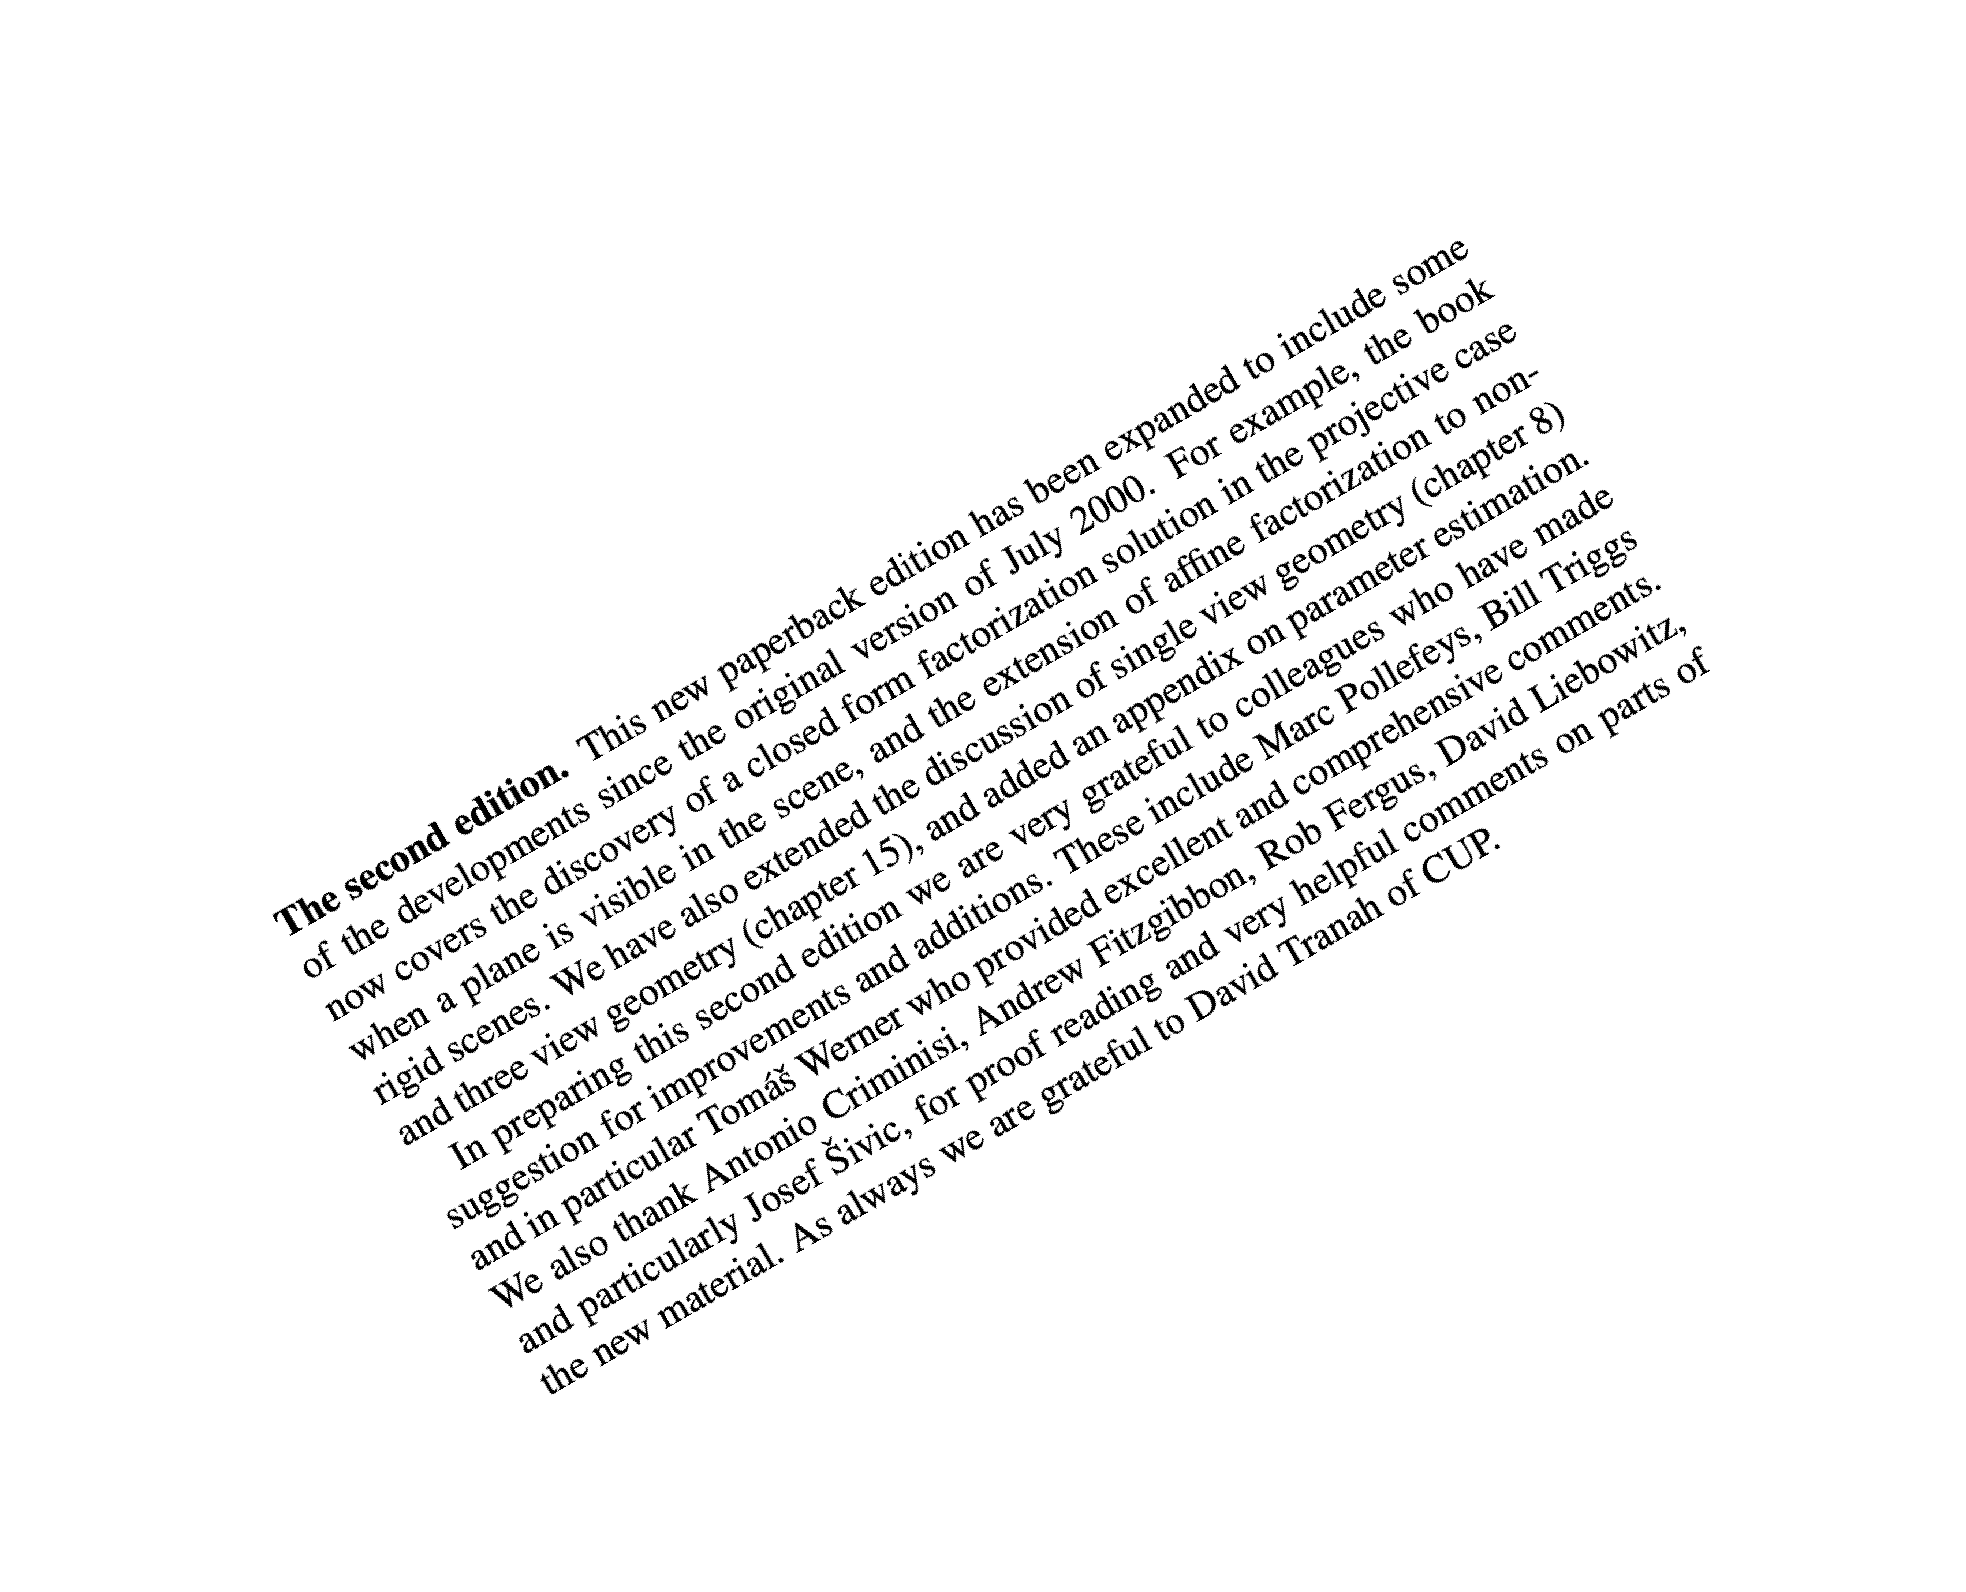

.
3 passed in 0.10s


In [5]:
%%ipytest -s


import pytest
import tempfile
import shutil
from pathlib import Path
import base64
from app import lambda_handler
from IPython.display import Image, display

@pytest.fixture(scope="function")
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "test_image.png")
    
    yield Path(directory)
    
    shutil.rmtree(directory)

@pytest.fixture(scope="function")
def lambda_event(directory):
    test_image_path = directory / "input" / "test_image.png"
    with open(test_image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
    return {"body": encoded_image}

def test_lambda_handler_status_code(lambda_event):
    context = {}
    result = lambda_handler(lambda_event, context)
    assert result['statusCode'] == 200, "The lambda function should return a status code of 200."

def test_lambda_handler_body_present(lambda_event):
    context = {}
    result = lambda_handler(lambda_event, context)
    assert 'body' in result and len(result['body']) > 0, "The lambda function should return a body with the processed image in base64."

def test_lambda_handler_output_image(directory, lambda_event):
    context = {}
    result = lambda_handler(lambda_event, context)
    
    processed_image_base64 = result['body']
    processed_image_bytes = base64.b64decode(processed_image_base64)
    output_image_path = directory / "output.png"
    
    with open(output_image_path, "wb") as image_file:
        image_file.write(processed_image_bytes)
    
    assert output_image_path.exists(), "The output image file should exist."
    assert output_image_path.stat().st_size > 0, "The output image file should not be empty."
    
    # Mostra a imagem processada
    display(Image(filename=str(output_image_path)))



In [3]:
%%ipytest -s

import pytest
import tempfile
import shutil
from pathlib import Path
import base64
from app import lambda_handler


@pytest.fixture(scope="function")
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "test_image.png")
    
    directory = Path(directory)
    
    yield directory
    
    shutil.rmtree(directory)

def test_lambda_handler(directory):
    # Codifica a imagem de teste em base64
    test_image_path = directory / "input" / "test_image.png"
    with open(test_image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
    
    # Simula um evento de entrada para a função lambda
    event = {"body": encoded_image}
    context = {}
    
    # Chama a função lambda_handler com o evento de teste
    result = lambda_handler(event, context)
    
    # Verifica se o statusCode retornado é 200
    assert result['statusCode'] == 200
    
    # Verifica se a imagem foi de fato processada e retornada como base64
    # Aqui você pode adicionar verificações mais específicas dependendo de como sua imagem é processada
    assert 'body' in result
    assert len(result['body']) > 0



.
1 passed in 0.06s
